In [1]:
import os
import pandas as pd
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from torchvision import transforms
from torchvision.transforms import Resize, ToTensor, Normalize

## train_image.csv 만들기

In [3]:
import os

class_number = {
    'mask':0, 'inco':6, 'norm':12,
    'male':0, 'female':3 
    }

train_folder = '/opt/ml/input/data/train/images'
image_names = []
for subdir in os.listdir(train_folder):
    if subdir.startswith("."):
        continue
    
    name_class = subdir.split('_')
    folder_class = 0
    folder_class += class_number[name_class[1]]

    age = int(name_class[3]) 
    if age < 30:
        folder_class += 0
    elif 30 <= age < 60:
        folder_class += 1
    elif 60 <= age:
        folder_class += 2
    
    subdir_path = train_folder + '/' + subdir
    for file_name in os.listdir(subdir_path):
        if not file_name.startswith("."):
            image_class = folder_class + class_number[file_name[:4]]
            image_path = subdir_path + '/' + file_name
            image_names.append([name_class[0], name_class[1] , name_class[2], age, image_path, image_class])

print(os.listdir(train_folder)[:3])
print(image_names[:5])

['._003456_male_Asian_56', '._000571_male_Asian_51', '006131_male_Asian_20']
[['006131', 'male', 'Asian', 20, '/opt/ml/input/data/train/images/006131_male_Asian_20/mask2.png', 0], ['006131', 'male', 'Asian', 20, '/opt/ml/input/data/train/images/006131_male_Asian_20/mask3.png', 0], ['006131', 'male', 'Asian', 20, '/opt/ml/input/data/train/images/006131_male_Asian_20/mask5.png', 0], ['006131', 'male', 'Asian', 20, '/opt/ml/input/data/train/images/006131_male_Asian_20/mask1.png', 0], ['006131', 'male', 'Asian', 20, '/opt/ml/input/data/train/images/006131_male_Asian_20/incorrect_mask.png', 6]]


In [4]:
import csv

image_names.sort()
image_names = [['id','gender','race','age','path', 'class']] + image_names

with open('train_image.csv', 'w') as file:
    write = csv.writer(file)
    write.writerows(image_names)


## train_image 분석

In [5]:
import pandas as pd

csv_path = "/opt/ml/code/train_image.csv"
train_image = pd.read_csv(csv_path)
print(train_image.sample(5))

          id  gender   race  age  \
8405  003161  female  Asian   20   
1338  000574  female  Asian   56   
6403  001668  female  Asian   48   
4763  001382  female  Asian   60   
7387  001925  female  Asian   50   

                                                   path  class  
8405  /opt/ml/input/data/train/images/003161_female_...      3  
1338  /opt/ml/input/data/train/images/000574_female_...      4  
6403  /opt/ml/input/data/train/images/001668_female_...      4  
4763  /opt/ml/input/data/train/images/001382_female_...      5  
7387  /opt/ml/input/data/train/images/001925_female_...      4  


In [6]:
print(train_image.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18900 entries, 0 to 18899
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      18900 non-null  object
 1   gender  18900 non-null  object
 2   race    18900 non-null  object
 3   age     18900 non-null  int64 
 4   path    18900 non-null  object
 5   class   18900 non-null  int64 
dtypes: int64(2), object(4)
memory usage: 886.1+ KB
None


In [7]:
print(train_image.describe(include='all'))

            id  gender   race           age  \
count    18900   18900  18900  18900.000000   
unique    2699       2      1           NaN   
top     003397  female  Asian           NaN   
freq        14   11606  18900           NaN   
mean       NaN     NaN    NaN     37.708148   
std        NaN     NaN    NaN     16.983208   
min        NaN     NaN    NaN     18.000000   
25%        NaN     NaN    NaN     20.000000   
50%        NaN     NaN    NaN     36.000000   
75%        NaN     NaN    NaN     55.000000   
max        NaN     NaN    NaN     60.000000   

                                                     path         class  
count                                               18900  18900.000000  
unique                                              18900           NaN  
top     /opt/ml/input/data/train/images/001482_female_...           NaN  
freq                                                    1           NaN  
mean                                                  NaN      5.

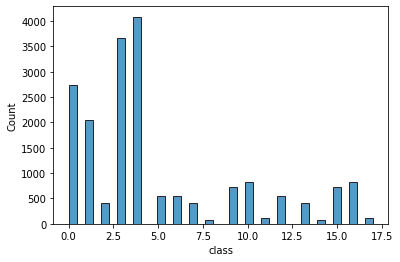

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.histplot(x='class',data=train_image, )
plt.show()

## Dataset

In [9]:
from PIL import Image

class CustomDataset(Dataset):
    def __init__(self, path, transform, train=True):
        train_image = pd.read_csv(path)
        self.train = train
        self.image_paths = train_image["path"]
        self.image_labels = train_image["class"]
        self.transform = transform

    def __len__(self):
        return len(self.image_labels)-1

    def __getitem__(self, idx):
        label = None
        img = Image.open(self.image_paths[idx])
        if self.train:
            label = torch.tensor(self.image_labels[idx])
        img_Tensor = self.transform(img)
        return img_Tensor, label
        


In [10]:
train_dataset = CustomDataset(csv_path, transform=transforms.ToTensor())
val_dataset = CustomDataset(csv_path, transform=transforms.ToTensor(), train=False)

In [11]:
next(iter(train_dataset))

(tensor([[[0.7490, 0.7490, 0.7490,  ..., 0.7882, 0.7882, 0.7882],
          [0.7490, 0.7490, 0.7490,  ..., 0.7882, 0.7882, 0.7882],
          [0.7490, 0.7490, 0.7490,  ..., 0.7882, 0.7882, 0.7882],
          ...,
          [0.5843, 0.5882, 0.5882,  ..., 0.5922, 0.5922, 0.5922],
          [0.5725, 0.5725, 0.5725,  ..., 0.5961, 0.5961, 0.5961],
          [0.5608, 0.5608, 0.5608,  ..., 0.6078, 0.6078, 0.6078]],
 
         [[0.7451, 0.7451, 0.7451,  ..., 0.7843, 0.7843, 0.7843],
          [0.7451, 0.7451, 0.7451,  ..., 0.7843, 0.7843, 0.7843],
          [0.7451, 0.7451, 0.7451,  ..., 0.7843, 0.7843, 0.7843],
          ...,
          [0.3804, 0.3843, 0.3843,  ..., 0.3686, 0.3686, 0.3686],
          [0.3686, 0.3686, 0.3686,  ..., 0.3725, 0.3725, 0.3725],
          [0.3569, 0.3569, 0.3569,  ..., 0.3686, 0.3686, 0.3686]],
 
         [[0.7255, 0.7255, 0.7255,  ..., 0.7647, 0.7647, 0.7647],
          [0.7255, 0.7255, 0.7255,  ..., 0.7647, 0.7647, 0.7647],
          [0.7255, 0.7255, 0.7255,  ...,

In [12]:
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=1)
val_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=1)

In [13]:
next(iter(train_dataloader))

[tensor([[[[0.4706, 0.4627, 0.4510,  ..., 0.4471, 0.5059, 0.4706],
           [0.4784, 0.4627, 0.4510,  ..., 0.4745, 0.5529, 0.5608],
           [0.4824, 0.4706, 0.4549,  ..., 0.5098, 0.5961, 0.6314],
           ...,
           [0.1059, 0.0824, 0.0667,  ..., 0.4980, 0.4745, 0.4314],
           [0.1333, 0.1098, 0.0902,  ..., 0.5216, 0.4824, 0.4275],
           [0.1373, 0.1137, 0.0980,  ..., 0.5373, 0.4980, 0.4275]],
 
          [[0.4392, 0.4235, 0.4118,  ..., 0.4431, 0.5020, 0.4667],
           [0.4392, 0.4235, 0.4118,  ..., 0.4706, 0.5490, 0.5569],
           [0.4431, 0.4235, 0.4078,  ..., 0.5059, 0.5922, 0.6275],
           ...,
           [0.0902, 0.0863, 0.0745,  ..., 0.4314, 0.4392, 0.4235],
           [0.1294, 0.1098, 0.1098,  ..., 0.4627, 0.4667, 0.4275],
           [0.1373, 0.1216, 0.1176,  ..., 0.4863, 0.4824, 0.4353]],
 
          [[0.4314, 0.4196, 0.4078,  ..., 0.4275, 0.4863, 0.4510],
           [0.4353, 0.4196, 0.4078,  ..., 0.4549, 0.5333, 0.5412],
           [0.4392, 0.42

In [14]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print ("device:[%s]."%(device))

device:[cuda:0].


In [15]:
from torchvision import models
model_resnet = models.resnet18(pretrained=True)
num_ftrs = model_resnet.fc.in_features
model_resnet.fc = nn.Linear(num_ftrs, 18)

In [16]:
model_resnet

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [17]:
import math

torch.nn.init.xavier_uniform_(model_resnet.fc.weight)
stdv = 1. / math.sqrt(model_resnet.fc.weight.size(1))
model_resnet.fc.bias.data.uniform_(-stdv, stdv)
print("네트워크 출력 채널 개수 (예측 class type 개수)", model_resnet.fc.weight.shape[0])

네트워크 출력 채널 개수 (예측 class type 개수) 18


In [18]:
model_resnet.to(device) # Resnent 18 네트워크의 Tensor들을 GPU에 올릴지 Memory에 올릴지 결정함

LEARNING_RATE = 0.0001 # 학습 때 사용하는 optimizer의 학습률 옵션 설정
NUM_EPOCH = 5 # 학습 때 mnist train 데이터 셋을 얼마나 많이 학습할지 결정하는 옵션

loss_fn = torch.nn.CrossEntropyLoss() # 분류 학습 때 많이 사용되는 Cross entropy loss를 objective function으로 사용 - https://en.wikipedia.org/wiki/Cross_entropy
optimizer = torch.optim.Adam(model_resnet.parameters(), lr=LEARNING_RATE) # weight 업데이트를 위한 optimizer를 Adam으로 사용함


In [22]:
NUM_EPOCH = 10
log_interval = 100 # 로그를 보기위한 간격


# Training
for epoch in range(1, NUM_EPOCH + 1):
  # Train Mode
  model_resnet.train()
    
  for batch_idx, (data, target) in enumerate(train_dataloader):
    data, target = data.to(device), target.to(device)
    optimizer.zero_grad()
    output = model_resnet(data)
    loss = loss_fn(output, target)
    loss.backward()
    optimizer.step()
    
    if batch_idx % log_interval == 0:
      print('Train_Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
      	epoch, batch_idx * len(data), len(train_dataloader.dataset),
      	100 * batch_idx / len(train_dataloader), loss.item()
      ))

Train_Epoch: 1 [0/18899 (0%)]	Loss: 0.000559
Train_Epoch: 1 [6400/18899 (34%)]	Loss: 0.000967
Train_Epoch: 1 [12800/18899 (68%)]	Loss: 0.002054
Train_Epoch: 2 [0/18899 (0%)]	Loss: 0.000696
Train_Epoch: 2 [6400/18899 (34%)]	Loss: 0.033600
Train_Epoch: 2 [12800/18899 (68%)]	Loss: 0.008991
Train_Epoch: 3 [0/18899 (0%)]	Loss: 0.053249
Train_Epoch: 3 [6400/18899 (34%)]	Loss: 0.010896
Train_Epoch: 3 [12800/18899 (68%)]	Loss: 0.010211
Train_Epoch: 4 [0/18899 (0%)]	Loss: 0.000609
Train_Epoch: 4 [6400/18899 (34%)]	Loss: 0.000564
Train_Epoch: 4 [12800/18899 (68%)]	Loss: 0.000174
Train_Epoch: 5 [0/18899 (0%)]	Loss: 0.002156
Train_Epoch: 5 [6400/18899 (34%)]	Loss: 0.001213
Train_Epoch: 5 [12800/18899 (68%)]	Loss: 0.001619
Train_Epoch: 6 [0/18899 (0%)]	Loss: 0.000361
Train_Epoch: 6 [6400/18899 (34%)]	Loss: 0.000457
Train_Epoch: 6 [12800/18899 (68%)]	Loss: 0.000452
Train_Epoch: 7 [0/18899 (0%)]	Loss: 0.000195
Train_Epoch: 7 [6400/18899 (34%)]	Loss: 0.000177
Train_Epoch: 7 [12800/18899 (68%)]	Loss: 0

In [31]:
class TestDataset(Dataset):
    def __init__(self, img_paths, transform):
        self.img_paths = img_paths
        self.transform = transform

    def __getitem__(self, index):
        image = Image.open(self.img_paths[index])

        if self.transform:
            image = self.transform(image)
        return image

    def __len__(self):
        return len(self.img_paths)

In [32]:
test_dir = '/opt/ml/input/data/eval'
# meta 데이터와 이미지 경로를 불러옵니다.
submission = pd.read_csv(os.path.join(test_dir, 'info.csv'))
image_dir = os.path.join(test_dir, 'images')

# Test Dataset 클래스 객체를 생성하고 DataLoader를 만듭니다.
image_paths = [os.path.join(image_dir, img_id) for img_id in submission.ImageID]

test_dataset = TestDataset(image_paths, transform=transforms.ToTensor())

test_loader = DataLoader(test_dataset,shuffle=False)


In [34]:
model_resnet.eval()

# 모델이 테스트 데이터셋을 예측하고 결과를 저장합니다.
all_predictions = []
for images in test_loader:
    with torch.no_grad():
        images = images.to(device)
        pred = model_resnet(images)
        pred = pred.argmax(dim=-1)
        all_predictions.extend(pred.cpu().numpy())
submission['ans'] = all_predictions

# 제출할 파일을 저장합니다.
submission.to_csv(os.path.join(test_dir, 'submission.csv'), index=False)
print('test inference is done!')

test inference is done!
